The purpose of this notebook is to gain a deeper understanding of linear regression by applying it to the "Credit" dataset. I will try to go through the steps from pre processing the data to checking the model assumptions.

Steps taken:
1. Clean data 
2. Quick analysis
3. Build simple model
4. Check model assumptions
    - linearity
    - normality
    - homoscedasticity
    - no multicollinearity

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm
import statsmodels as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [3]:
plt.style.use('ggplot')

# 1. Clean data

In [4]:
df = pd.read_csv('credit.csv')

In [5]:
df.head(5)

,Unnamed: 0,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [6]:
#drop column
df.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
#quick info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         400 non-null    int64  
 1   Income     400 non-null    float64
 2   Limit      400 non-null    int64  
 3   Rating     400 non-null    int64  
 4   Cards      400 non-null    int64  
 5   Age        400 non-null    int64  
 6   Education  400 non-null    int64  
 7   Gender     400 non-null    object 
 8   Student    400 non-null    object 
 9   Married    400 non-null    object 
 10  Ethnicity  400 non-null    object 
 11  Balance    400 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB


In [8]:
#drop column
df.drop(columns=['ID'], inplace=True)

In [9]:
#check for NA values
df.isna().sum()

Income       0
Limit        0
Rating       0
Cards        0
Age          0
Education    0
Gender       0
Student      0
Married      0
Ethnicity    0
Balance      0
dtype: int64

# 2. Quick analysis

## Distribution & Outliers

In order to look at the distribution and to identify outliers I will plot histograms and violin plots for all the numerical variables. Furthermore I will use the IQR method to identify potential outliers. According to the IQR method, there are quite a few outliers for the variable Income. However, it is very likely that we will find a few high-earners in this data set and thus, I will not treat data points outside of the ```Q1-1.5*IQR```and ```Q3+1.5*IQR``` range as outliers. Since the highest earners also have a high Limit as well as Rating value, I will also not classify those data points as outliers either. 
For the Cards variable, I will remove the 2 entries with more than 7 credit cards. The amount of credit cards just doesn't make sense to me, especially when considering the associated income.

In [10]:
numeric = df[["Income", "Limit", "Rating", "Cards", "Age", "Education", "Balance"]]

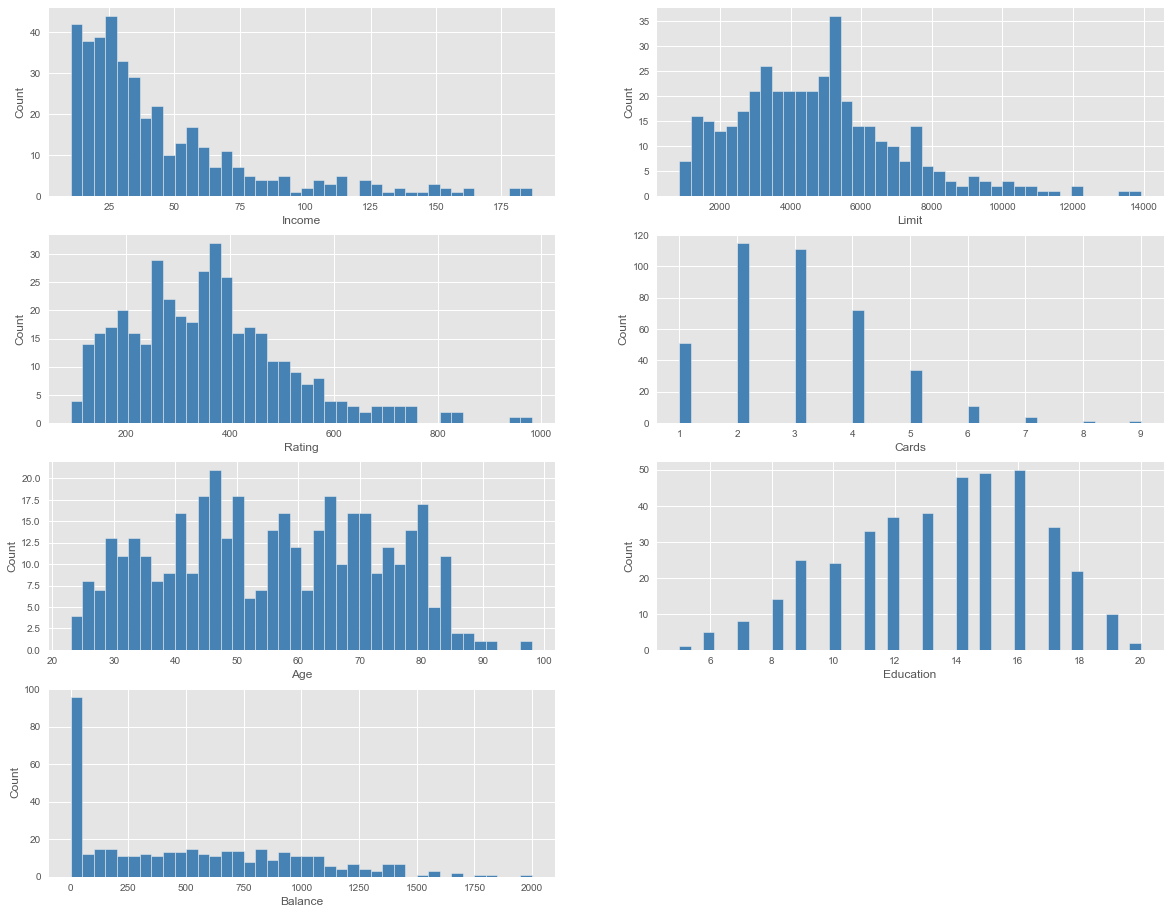

In [11]:
f, axes = plt.subplots(4, 2, figsize=(20, 16))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2, 3]
mylist2 = [0, 1, 0, 1, 0, 1, 0]
for i, j in enumerate(numeric.columns): #i: axes locations, j: column names
    sns.histplot(x=df[j], ax=axes[mylist1[i], mylist2[i]], bins=40, color="steelblue", alpha=1)
    
f.delaxes(axes[3,1])

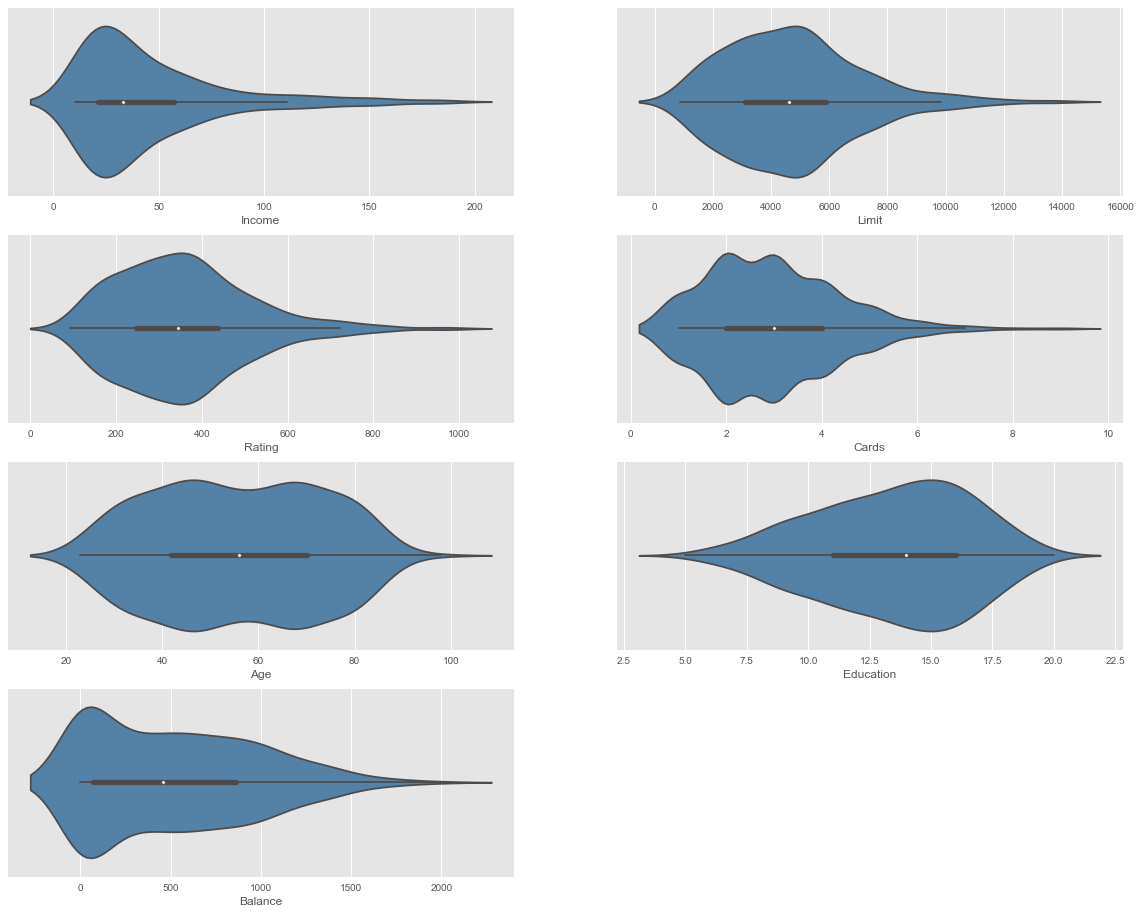

In [12]:
f, axes = plt.subplots(4, 2, figsize=(20, 16))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1], [3,0]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2, 3]
mylist2 = [0, 1, 0, 1, 0, 1, 0]
for i, j in enumerate(numeric.columns): #i: axes locations, j: column names
    sns.violinplot(x=df[j], ax=axes[mylist1[i], mylist2[i]], color="steelblue")
    
f.delaxes(axes[3,1])

In [13]:
#cards > 7
df[df['Cards']>7]

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
205,10.793,3878,321,8,29,13,Male,No,No,Caucasian,638
383,14.292,3274,282,9,64,9,Male,No,Yes,Caucasian,382


In [14]:
df['Cards'].value_counts()

2    115
3    111
4     72
1     51
5     34
6     11
7      4
9      1
8      1
Name: Cards, dtype: int64

In [15]:
#remove Cards > 7
df = df[~(df['Cards']>7)]

In [16]:
df[df['Cards']>7]

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance


# 3. Build simple model

In this step I am going to build a very simple linear regression model containing all variables and evaluate the cross-validated RMSE. Training the linear regression model using 5-fold cross-validation results in a RSME of 10.3 (average RMSE across the 5 CV folds). This means when applied to unseen data, the predictions this model makes are, on average, about 10.3 rating points off from the actual rating score.

In [68]:
#split data
X = df.drop(columns=['Rating'])
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

#transform columns
column_trans = make_column_transformer(
    (OneHotEncoder(), ["Gender", "Student", "Married", "Ethnicity"]), 
    remainder = "passthrough")

#define regression model
linreg = LinearRegression()

#make pipeline
pipe = make_pipeline(column_trans, linreg)

#5 fold cross validation of linreg model
cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()

#RMSR score
print("RMSE: {:.7f}".format(sqrt(abs(cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error").mean()))))

RMSE: 10.3028778


# 4. Check model assumptions

The linear regression model underlies strong assumptions that are often violated which leads to flawed interpretations and prediction results. In this step I will check these assumptions.

## Linearity

**How to detect:** 
* We can look at the scatter plots of the dependent variable and the independent variables individually to gain insights on linearity. As we can see, the independent variables seem to have a mostly linear relationship to the outcome variable.
* Another way to check linearity is to look at the residuals vs predicted plot. The data points should be symmetrically distributed around the horizontal line with roughly constant variances. As we observe, we don't have perfect linearity, but we are very close to it.
* Individual residual plots
* Actual vs predicted

**How to fix:** We can apply a log transformation to the dependent and/or independent variables if the values are strictly positive.

### Scatter plots (independent variables vs dependent variable)

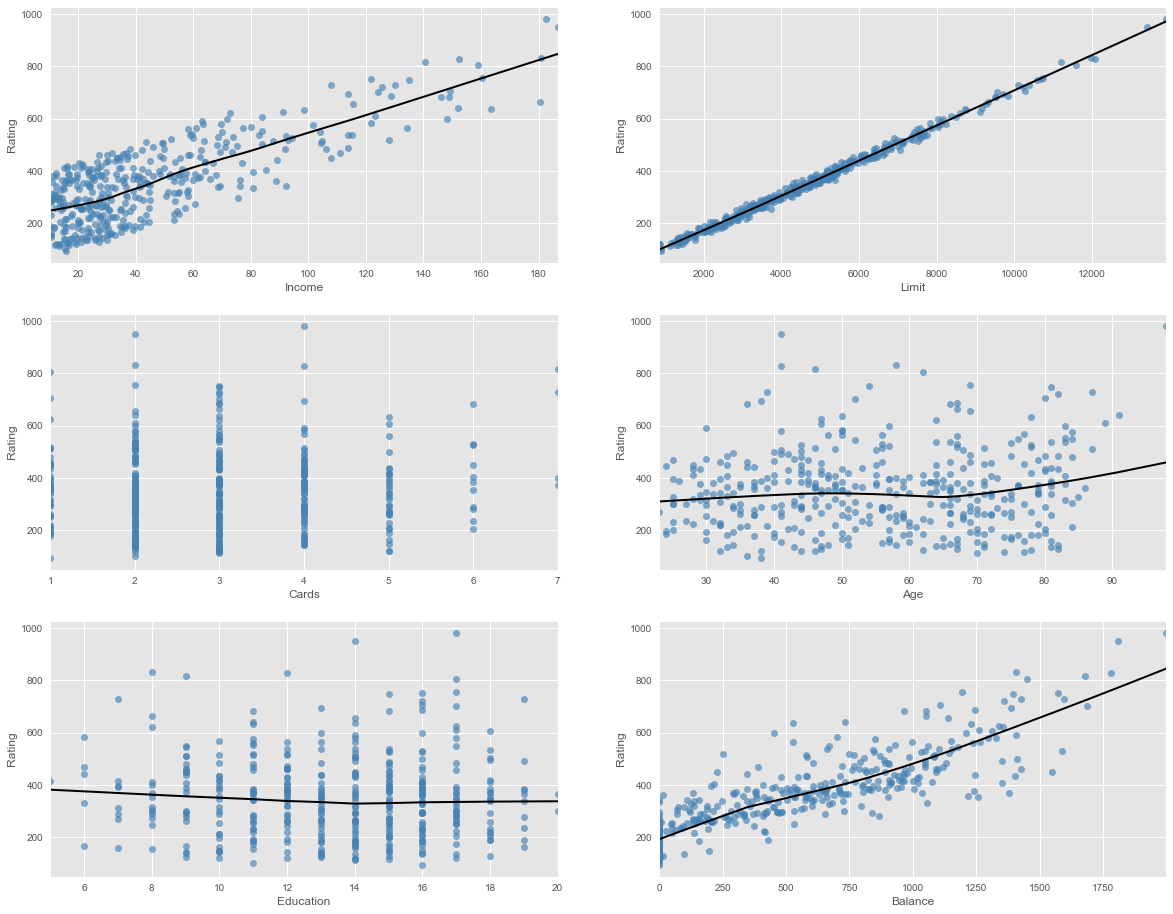

In [21]:
f, axes = plt.subplots(3, 2, figsize=(20, 16))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.drop(columns=["Rating"]).columns): #numeric columns without "Rating"
    sns.regplot(x=df[j], y=df["Rating"], #i: axes locations, j: column names
            ax=axes[mylist1[i],mylist2[i]],
            lowess=True, #line of best fit
            scatter_kws={"alpha":0.65, "color":"steelblue"}, #scatter points alpha
            line_kws={"color":"black", "lw":2}) #line width & color

### Residual plot

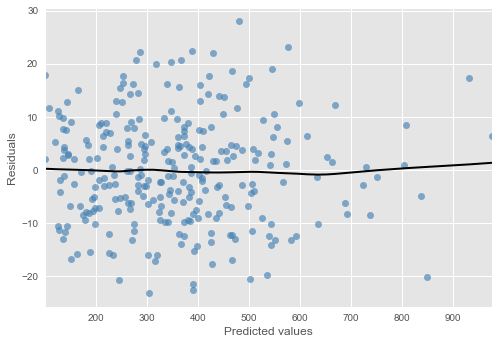

In [22]:
#run model on test data

#model predictions
pipe.fit(X_train, y_train)
predictions = pipe.predict(X_train)

#residuals
residuals = y_train - predictions

#residual plot
ax = sns.regplot(x=predictions, y=residuals, 
            scatter_kws={"alpha":0.65, "color":"steelblue"},
            lowess=True,
            line_kws={"color":"black", "lw":2})
ax.set(xlabel='Predicted values', ylabel='Residuals')

plt.show()

### Individual residual plots

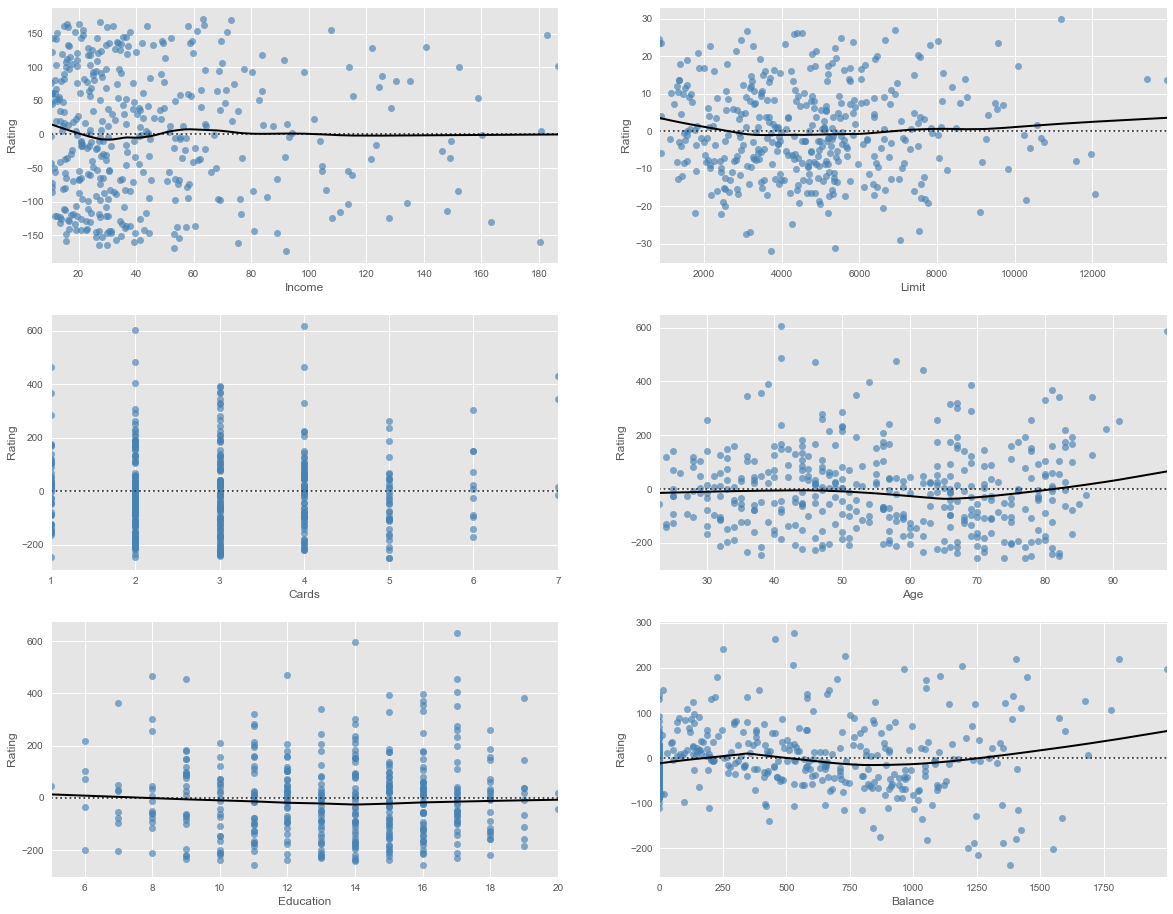

In [31]:
f, axes = plt.subplots(3, 2, figsize=(20, 16))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]] axes locations
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.drop(columns=["Rating"]).columns): #numeric columns without "Rating"
    sns.residplot(x=df[j], y=df["Rating"], #i: axes locations, j: column names
            ax=axes[mylist1[i],mylist2[i]],
            lowess=True, #line of best fit
            scatter_kws={"alpha":0.65, "color":"steelblue"}, #scatter points alpha
            line_kws={"color":"black", "lw":2}) #line width & color

### Actual vs predicted plot

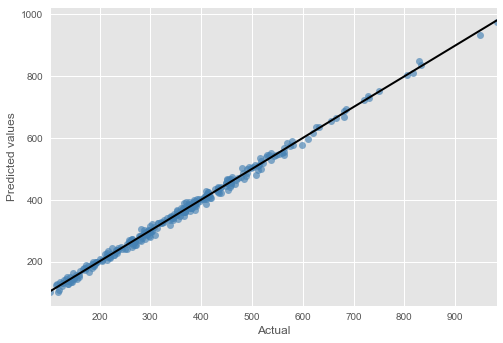

In [23]:
ax = sns.regplot(x=y_train, y=predictions, 
            scatter_kws={"alpha":0.65, "color":"steelblue"},
            lowess=True,
            line_kws={"color":"black", "lw":2})
ax.set(xlabel='Actual', ylabel='Predicted values')
plt.show()

## Normality

**How to detect:** It is a very common misconception that the model require the independent variables and the dependent variable to be normally distributed. Normality is required only from the residuals.

* We can detect normality of the residuals plotting a density plot and looking at the distribution compared to the normal distribution. In this case, the distribution seems to be normal.  
* Another way is to look at the qqplot. The data points should be distributed closely along the line. In this case, the normaliy assumption does not seem to be violated by a lot.
* Lastly, we can do a variety of statistical tests to check for normality, for example the Jarque-Bera test. The H0 hypothesis for this test is that the data follows a normal distribution. The test tests if skewness is 0 and kurtosis is 3, which are the values for a normal distribution. A very small p-value (<0.05) means we can reject the H0 hypothesis that the data is normal, thus our data does not follow a normal distribution. 

In our case, the densitiy plot shows that the residuals follow a normal distribution. Furthermore the data points are distributed closely along the line. Lastly, we get a p-value of 0.266 which is larger than 0.05. This means we fail to reject the H0 hypothesis and thus, our residuals are normally distributed.

**How to fix:** We can apply a log transformation to the dependent and/or independent variables if the values are strictly positive.

c:\users\nam\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


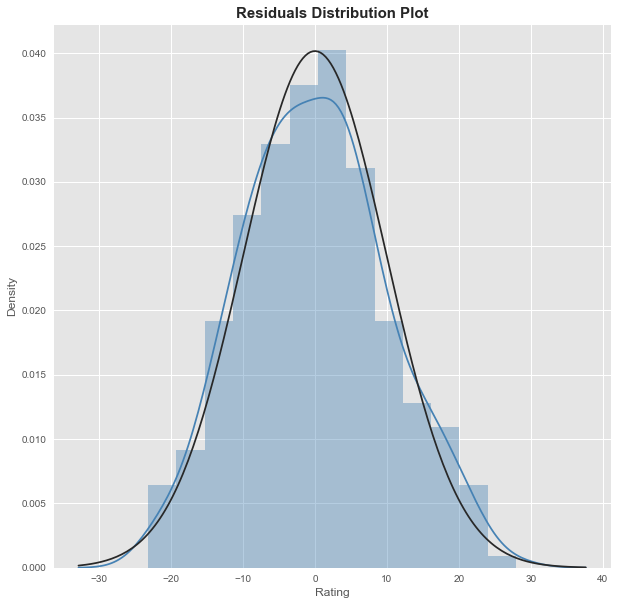

In [25]:
plt.figure(figsize=(10,10))
sns.distplot(residuals, fit=norm, color="steelblue")
plt.title("Residuals Distribution Plot",size=15, weight='bold')

plt.show()

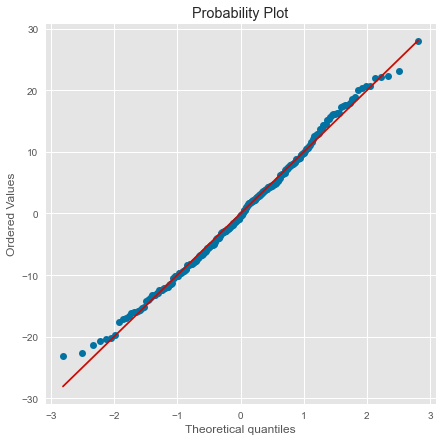

In [26]:
plt.figure(figsize=(7,7))
stats.probplot(residuals, plot=plt)
plt.show()

In [27]:
stats.jarque_bera(residuals)

Jarque_beraResult(statistic=2.6473718270707334, pvalue=0.2661524767576473)

## Homoscedastiscity

**How to detect:** 
* We can have a look at the residuals vs. predicted values. If the residuals systematically increase, it's a sign for heteroscedasticity. To be really thorough, we will also look at the residuals vs independent variable plots. In our case there is no significant amount of systematically incresing residuals (except for the variable Balance, though only slightly).
* Another way of testing for heteroscedasticity is the White test. a p-value of <0.05 indicates heteroscedasticity. In our case we get a p-value of 0.73 and thus, we can assume that our data is homoscedastic. 

**How to fix:** In case of heteroscedasticity, we can once again apply a log transformation to the dependent variable.

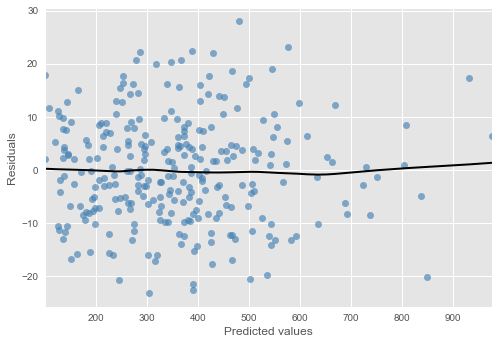

In [28]:
#residual plot
ax = sns.regplot(x=predictions, y=residuals, 
            scatter_kws={"alpha":0.65, "color":"steelblue"},
            lowess=True,
            line_kws={"color":"black", "lw":2})
ax.set(xlabel='Predicted values', ylabel='Residuals')

plt.show()

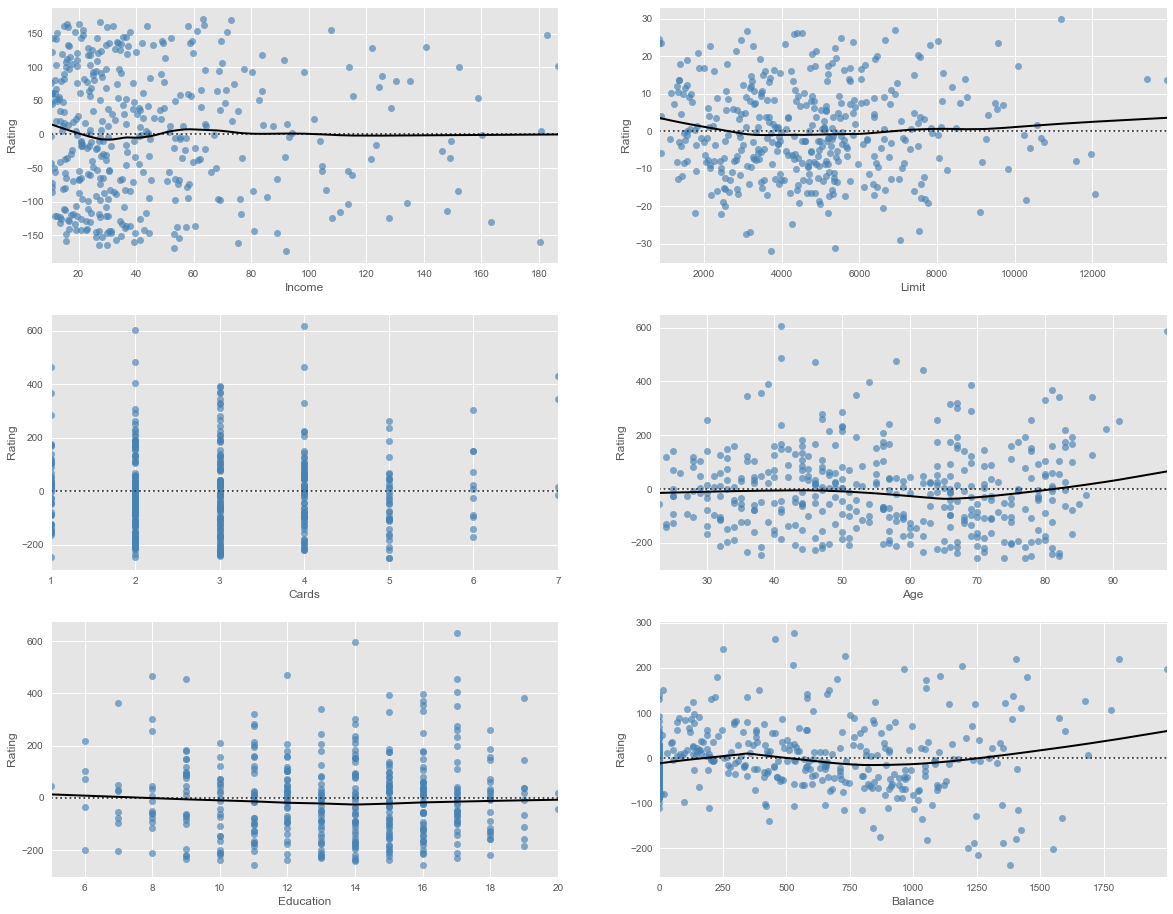

In [29]:
f, axes = plt.subplots(3, 2, figsize=(20, 16))
#mylist = [[0,0], [0,1], [1,0], [1,1], [2,0], [2,1]] axes locations, #location == #graphs
mylist1 = [0, 0, 1, 1, 2, 2]
mylist2 = [0, 1, 0, 1, 0, 1]
for i, j in enumerate(numeric.drop(columns=["Rating"]).columns): #numeric columns without "Rating"
    sns.residplot(x=df[j], y=df["Rating"], #i: axes locations, j: column names
            ax=axes[mylist1[i],mylist2[i]],
            lowess=True, #line of best fit
            scatter_kws={"alpha":0.65, "color":"steelblue"}, #scatter points alpha
            line_kws={"color":"black", "lw":2}) #line width & color

In [47]:
#new X_train variable for the test
X_train_new = column_trans.fit_transform(X_train)

#define white test
white_test = het_white(residuals, X_train_new)

#define labels
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]

#print results
print(dict(zip(labels, white_test)))

{'LM Statistic': 63.22655857278002, 'LM-Test p-value': 0.7327911557037975, 'F-Statistic': 0.8541375978937031, 'F-Test p-value': 0.7782395321002451}


## Multicollinearity

**How to detect:** 
* We can detect Multicollinearity of numeric variables by looking at the VIF score of the (numeric) variables. Variables with very large VIF scores should be removed. In this case the variables Income, Limit and Balance have very high VIF score. 
* Another way to detect multicollinearity is to look at the eigen values of the correlation matrix. If at least one eigen value is close to 0, we have multicollinearity.

In our case we can see from the correlation plot that the variables Limit, Income and Balance show high correlations with each other. Looking at the VIF values confirms this. Lastly, we can get an eigen value that is close to 0. Thus, we have multicollinearity.
I am not going to remove these variables since they seem to be very significant for the prediction. Any advice on how I should proceed at this point is very welcomed.

### VIF

In [71]:
X_train_num = X_train.select_dtypes('number')
#from statsmodels.tools.tools import add_constant

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X_train_num.values, i) for i in range(X_train_num.shape[1])]
vif["features"] = X_train_num.columns

vif['VIF'] = vif['VIF'].apply(lambda x: "{:.2f}".format(x))
vif

,VIF,features
0,12.55,Income
1,73.47,Limit
2,5.37,Cards
3,9.81,Age
4,10.83,Education
5,17.67,Balance


### eigen values

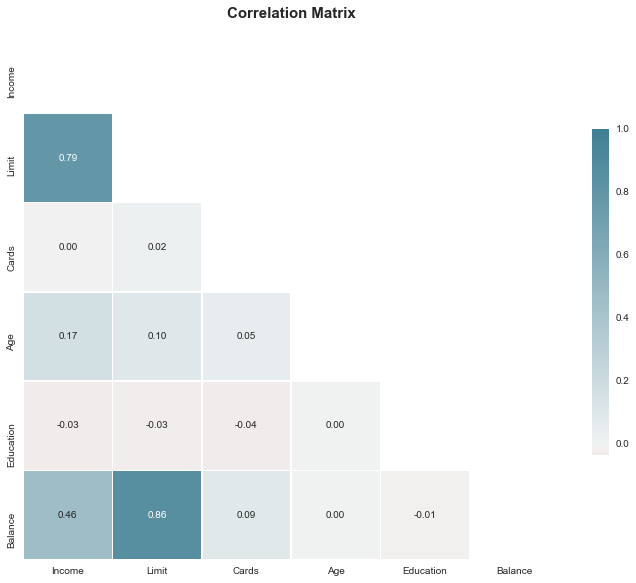

In [72]:
plt.figure(figsize=(12,12))
palette = sns.diverging_palette(20, 220, n=256)
corr=df.drop(columns=["Rating"]).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
with sns.axes_style("whitegrid"): #temporary whitegrid style
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=1, center=0,
                mask=mask, square=True, linewidths=0.5, cbar_kws={"shrink": .5})
    plt.title("Correlation Matrix",size=15, weight='bold')

plt.show()

In [67]:
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([2.44743392, 0.03579973, 0.49522329, 0.96164283, 1.01168382,
       1.04821641])